# Step 1 - Select S&P500 Dataset and Schiller P/E-10 Dataset from the URLs

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skimage import color
from skimage.transform import rescale, resize,downscale_local_mean

import matplotlib.pyplot as plt
print("Data of S&P 500")
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)
print("Data of PE Ration")
data_pe = pd.read_csv('S&P500 Schiller PE ratio.csv')
print(data_pe)
test=False

Data of S&P 500
           Date  Close/Last Vol.     Open     High      Low
0    12/01/2021     4766.18    -  4623.80  4808.52  4494.20
1    11/01/2021     4567.00    -  4616.47  4743.74  4560.26
2    10/01/2021     4605.38    -  4324.71  4608.70  4278.70
3    09/01/2021     4307.54    -  4531.04  4544.58  4304.90
4    08/01/2021     4522.68    -  4415.90  4537.80  4369.20
..          ...         ...  ...      ...      ...      ...
618  06/01/1970       72.72    -    76.55    79.96    72.25
619  05/01/1970       76.55    -    81.52    82.32    68.61
620  04/01/1970       81.52    -    89.63    90.70    79.31
621  03/01/1970       89.63    -    89.50    91.07    86.19
622  02/01/1970       89.50    -    85.02    90.33    84.64

[623 rows x 6 columns]
Data of PE Ration
           DateTime  SP500PERatio
0     1/2/1970 0:00         15.35
1     1/3/1970 0:00         15.75
2     1/4/1970 0:00         15.37
3     1/5/1970 0:00         13.69
4     1/6/1970 0:00         13.69
..              ..

# Step 2 - Develop and test/verify a correlation-based algorithm

In [2]:
date_pe = data_pe[["DateTime"]].to_numpy(dtype = "str")
date_sp = dataframe[["Date"]].to_numpy(dtype = "str")

date_pe = np.flip(date_pe)
date_sp = np.flip(date_sp)


ratio_sp = data_pe['SP500PERatio'].to_numpy(dtype = 'float')
mean_sp = ratio_sp.mean()
max_sp = ratio_sp.max()
median_sp = np.median(ratio_sp)
print("Mean PE: ",mean_sp)
print("Max PE: ",max_sp)
print("Median PE: ",median_sp)

sp_index = dataframe[["Close/Last", "Open"]].to_numpy(dtype = 'float')
mean_sp_index = sp_index[:,0].mean()
mean_sp_index1 = sp_index[:,1].mean()

Mean PE:  19.827191011235957
Max PE:  123.73
Median PE:  18.08


In [3]:
#Merge the data of S$P500 and PE ration
record = []
recordDate = []

# get the date from data
def get_date(date_data):
    res = (date_data[:-5]).split('/')
    if(len(res)==3):
        return res
    return None

array_date_pe = date_pe.tolist()

# if the S&P and PE in the same year and month, merge it into an item.

for i in range(len(date_sp)):
    tmp = [0 for _ in range(3)]
    tmp[0] = sp_index[i][0]
    record_time = str(date_sp[i][0])
    for j in range(len(ratio_sp)):
        peDate = get_date( array_date_pe[j][0] )

        if(peDate is not None and len(peDate)==3) :
            if(record_time[6:10]==peDate[2] ):
                    if(peDate[1]==record_time[0:2] or ('0'+peDate[1])==record_time[0:2]):
                        tmp[1] = ratio_sp[j]
                        recordDate.append(record_time)
                        record.append(tmp)

dataset = np.array(record)
    

In [4]:
# Calculate the correlation scores

sampleNum = 100
for i in range(sampleNum-1 ,len(dataset)):
    # Pearson  r
    x = dataset[(i-sampleNum+1):(i+1), 0]
    y = dataset[(i-sampleNum+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset[i][2] = r[0,1] 
dataset

array([[4.76618000e+03, 2.66600000e+01, 0.00000000e+00],
       [4.56700000e+03, 2.66100000e+01, 0.00000000e+00],
       [4.60538000e+03, 2.54400000e+01, 0.00000000e+00],
       ...,
       [8.15200000e+01, 1.53700000e+01, 5.04453481e-01],
       [8.96300000e+01, 1.57500000e+01, 5.07430364e-01],
       [8.95000000e+01, 1.53500000e+01, 5.05552796e-01]])

Text(0, 0.5, 'Correlation')

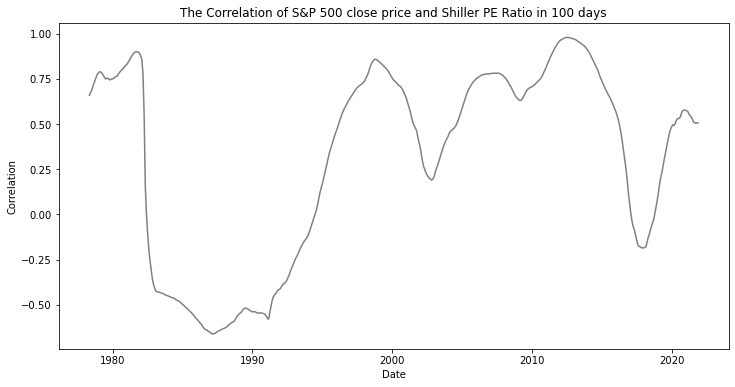

In [5]:
dateDigital = [];

for i in range(len(recordDate)):
    dateDigital.append(float(recordDate[i][6:10]) + ( (float(recordDate[i][0:2])-1)*30 + float(recordDate[i][3:5]) )/366 )

plt.figure(figsize=(12, 6));
plt.plot(dateDigital[(sampleNum-1):],
         dataset[(sampleNum-1):, 2], color='grey', label='Close')
plt.title('The Correlation of S&P 500 close price and Shiller PE Ratio in 100 days')
plt.xlabel('Date')
plt.ylabel('Correlation')

In [6]:
# Buy the sp when r>threshold
money = 1
money_all = []
trade_all = []
# Must buy the new stock before sell
lastsell=0

for i in range(sampleNum-1, dataset.shape[0]):
    corr_temp = dataset[i,2]
    price_temp = dataset[(i-sampleNum+1):(i+1), 0]
    if corr_temp > 0.5 and (i-lastsell > sampleNum):
        # sell at this point
        # buy at the local minia in this window interval (nsample interval)
        buy_price = min(price_temp)
        # in case of the overflow
        if buy_price > 0:           
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price*money
            lastsell = i
            print("Buy price: ",buy_price)
            print("Sell price: ",sell_price)
            print("Money: ",money)
            print(i)
            money_all.append(money)
            trade_all.append(i)


Buy price:  1632.97
Sell price:  1685.73
Money:  1.0323092279711201
101
Buy price:  581.5
Sell price:  581.5
Money:  1.0323092279711201
314
Buy price:  230.3
Sell price:  290.1
Money:  1.3003599958073033
415
Buy price:  96.11
Sell price:  96.11
Money:  1.3003599958073033
516
Buy price:  63.54
Sell price:  78.05
Money:  1.597310319055084
617


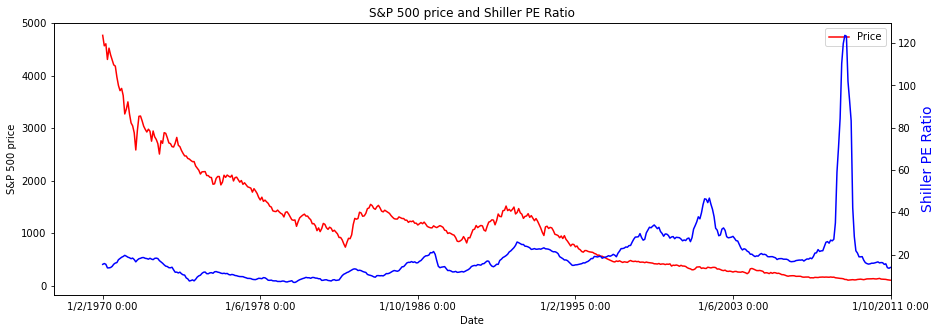

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(dataframe.Date, dataframe["Close/Last"].values, color = 'red', label='Price')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
ax2.set_xticks(ax2.get_xticks()[::100])
plt.xlim(-31.1,500.1)
# make a plot with different y-axis using second axis object
ax2.plot(data_pe.DateTime, data_pe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

Text(0, 0.5, 'Money/millions')

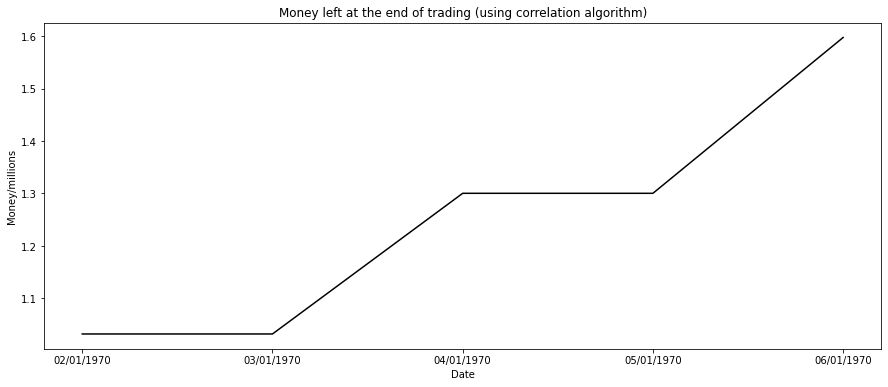

In [8]:
# Make a plot

date_trade = []
for i in range(len(trade_all)):
    date_trade.append(recordDate[i])
    
plt.figure(figsize=(15, 6))

plt.plot(date_trade,
         money_all, color='black', label='Close')
plt.title('Money left at the end of trading (using correlation algorithm)')
plt.xlabel('Date')
plt.ylabel('Money/millions')

# Step 3 - Design and develop a convolutional neural network (CNN) in Python that will recognize A-B-C-D-wave patterns

In [9]:
# Judge if their exist a A-B-C-D wave, if exist, save it.
sellSigIdx = []
prev = 0
for x in range(sampleNum-1, len(dataset)):
    if dataset[x][2] > 0.5 and x >= prev+sampleNum//3 and \
    dataset[x][0] == max(dataset[(x-sampleNum+1):(x+1), 0]) and \
    dataset[x][0] > dataset[x+1][0]:
        sellSigIdx.append(x)
        prev = x
sellSigIdx

[]

In [10]:
import torch.functional as F

class CNet(nn.Module):
    def __init__(self, linear_input=60):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=20,padding=2,padding_mode='replicate', kernel_size=5, stride=1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.ReLU = nn.ReLU()
        self.linear1 = nn.Linear(linear_input, 4)
        
    def forward(self, x):
        if(test==True):
            x = x.permute(0,2,1)
        else:
            x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        
        x =  self.ReLU( self.max_pool1(x) ) 
        
        x = x.view(x.size(0), -1)
        x = self.ReLU(self.linear1(x))
        x = x.unsqueeze(1)
        return x


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.cnn = CNet()
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.ReLU = nn.ReLU()
        
    
    def forward(self, x):
       
        x = self.cnn(x) 
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [11]:

trainData = dataframe[["Close/Last", "Open",'High','Low']].to_numpy(dtype = 'float')
targetData = dataframe[["Close/Last"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)
dateData = []
for i in range(date.shape[0]):
    dateData.append(float(np.squeeze(date)[i][6:10]) + ( (float(np.squeeze(date)[i][0:2])-1)*30 + float(np.squeeze(date)[i][3:5]) )/366 )
dateData = np.array(dateData)


In [12]:
window_size = 6
X = []
Y = []
for i in range(trainData.shape[0] - window_size - 4):
    X.append(trainData[i:i+window_size])
    Y.append(targetData[i+window_size:i+window_size+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
dateAxis = dateData[:-(window_size+4)]

In [13]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []


# 20% for test

# For the left 80% data, 80% * 80% =64% for train, 80% * 20% = 16% for valdation 
X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.2, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.2, shuffle=False)
date_test=date[438:623,:]

In [14]:
RNN = Model(input_size=4, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (cnn): CNet(
    (conv1): Conv1d(4, 20, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=replicate)
    (max_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ReLU): ReLU()
    (linear1): Linear(in_features=60, out_features=4, bias=True)
  )
  (rnn): RNN(4, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
  (ReLU): ReLU()
)

In [15]:
xTensor = torch.from_numpy(X_training).float()
xTensor_val = torch.from_numpy(X_validation).float()
yTensor = torch.Tensor(Y_training).float()
yTensor_val = torch.from_numpy(Y_validation).float()
epochs  =150

record_epoch = []
record_loss = []
record_loss_val = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    output_val, _ = RNN(xTensor_val)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss_val = criterion(output_val.reshape(-1), yTensor_val.view(-1))
    loss.backward()
    
    optimizer.step()
    record_epoch.append(epoch)
    record_loss.append(loss.item())
    record_loss_val.append(loss_val.item())
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Loss:", loss.item())

Epoch: 0/150............. Loss: 0.024663850665092468
Epoch: 10/150............. Loss: 0.007623069919645786
Epoch: 20/150............. Loss: 0.007348836865276098
Epoch: 30/150............. Loss: 0.007022053003311157
Epoch: 40/150............. Loss: 0.006356972735375166
Epoch: 50/150............. Loss: 0.0028948315884917974
Epoch: 60/150............. Loss: 0.0005139735294505954
Epoch: 70/150............. Loss: 0.00022968648409005255
Epoch: 80/150............. Loss: 0.00016123728710226715
Epoch: 90/150............. Loss: 0.00013025777298025787
Epoch: 100/150............. Loss: 0.00011781701323343441
Epoch: 110/150............. Loss: 0.00010767044295789674
Epoch: 120/150............. Loss: 0.0001043532247422263
Epoch: 130/150............. Loss: 0.00010018503962783143
Epoch: 140/150............. Loss: 9.698947542347014e-05


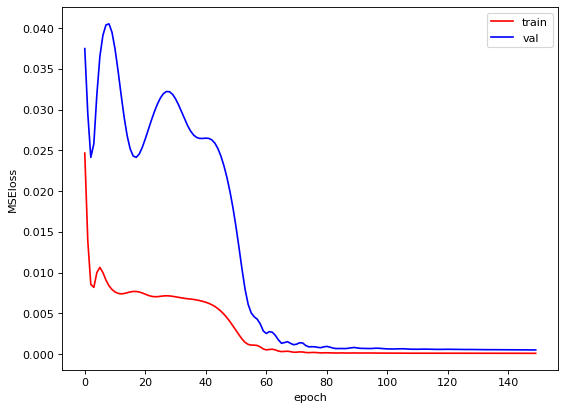

In [16]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(record_loss), 'r', label = 'train')
plt.plot(np.array(record_loss_val), 'b', label = 'val')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

# Step 4 - Train your CNN and RNN on your Training Set

In [17]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

# Calculate the accuracy, make a plot
def plotGraphs(output_1,output_2,output_3,output_4,Y_main,Y_plot,XAxis_date,date_pred,
    set1_title_1,set2_title_1,set3_title_1,set4_title_1,error_title):
    
    table = []

    error = prediction_error(output_1, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp1 = np.array(temp1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set1_title_1)

    ax1.plot(date_pred, output_1, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_2, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp2 = np.array(temp2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set2_title_1)
    ax1.plot(date_pred, output_2, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_3, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp3 = np.array(temp3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set3_title_1)
    ax1.plot(date_pred, output_3, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_4, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp4 = np.array(temp4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set4_title_1)
    ax1.plot(date_pred, output_plt4, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    temp1 = np.expand_dims(temp1, axis=1)
    temp2 = np.expand_dims(temp2, axis=1)
    temp3 = np.expand_dims(temp3, axis=1)
    temp4 = np.expand_dims(temp4, axis=1)
    table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
    ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
    col = ['1 day', '2 day', '3 day', '4 day']
    stats=pd.DataFrame(table, columns=col, index=ind).T
    display(stats)
    

# Calculate the accuracy, make a plot
def plotGraphsSD(output_1,output_2,output_3,output_4,Y_main,Y_plot,XAxis_date,date_pred,
    set1_title_1,set2_title_1,set3_title_1,set4_title_1,error_title,sd):
    
    cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown','blue' ]
    
    table = []
    error = []
    
    for index,threshold in enumerate(sd):
        error.append(prediction_error(output_1[index], Y_main))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set1_title_1)
    for index,threshold in enumerate(sd):
        ax1.plot(date_pred, np.squeeze(output_1[index]), color = cmaps[index], label = sd[index])
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    for index,threshold in enumerate(sd):
        ax2.plot(np.squeeze(date_pred), error[index], color = cmaps[index], label = sd[index])
    ax2.legend(loc="upper left")

    error = []
    for index,threshold in enumerate(sd):
        error.append(prediction_error(output_2[index], Y_main))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set2_title_1)
    for index,threshold in enumerate(sd):
        ax1.plot(date_pred, np.squeeze(output_2[index]), color = cmaps[index], label = sd[index])
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    for index,threshold in enumerate(sd):
        ax2.plot(np.squeeze(date_pred), error[index], color = cmaps[index], label = sd[index])
    ax2.legend(loc="upper left")

    error = []
    for index,threshold in enumerate(sd):
        error.append(prediction_error(output_3[index], Y_main))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set3_title_1)
    for index,threshold in enumerate(sd):
        ax1.plot(date_pred, np.squeeze(output_3[index]), color = cmaps[index], label = sd[index])
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    for index,threshold in enumerate(sd):
        ax2.plot(np.squeeze(date_pred), error[index], color = cmaps[index], label = sd[index])
    ax2.legend(loc="upper left")
    
    for index,threshold in enumerate(sd):
        error.append(prediction_error(output_4[index], Y_main))
    #error_dt = pd.DataFrame(data = error)
    #temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    #temp4 = np.array(temp4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set4_title_1)
    for index,threshold in enumerate(sd):
        ax1.plot(date_pred, np.squeeze(output_4[index]), color = cmaps[index], label = sd[index])
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    for index,threshold in enumerate(sd):
        ax2.plot(np.squeeze(date_pred), error[index], color = cmaps[index], label = sd[index])
    ax2.legend(loc="upper left")


def plotAccuracy(output_1,output_2,output_3,output_4,Y_main, date_pred, title_content ):
    
    table = []

    error_1 = prediction_error(output_1, Y_main)
    error_2 = prediction_error(output_2, Y_main)
    error_3 = prediction_error(output_3, Y_main)
    error_4 = prediction_error(output_4, Y_main)
    
    fig = plt.figure(figsize=(9, 5))
    plt.title(title_content)
    plt.plot(date_pred, error_1, color = 'blue', label = 't+1')
    plt.plot(date_pred, error_2, color = 'green', label = 't+2')
    plt.plot(date_pred, error_3, color = 'purple', label = 't+3')
    plt.plot(date_pred, error_4, color = 'red', label = 't+4')
    plt.legend(loc="upper left")
    
    plt.show()



,Mean,STD-dev,Skewness,Kurtosis
1 day,0.999860,0.000052,0.295745,-1.158199
2 day,0.999861,0.000052,0.283646,-1.169081
3 day,0.999862,0.000052,0.265355,-1.189195
4 day,0.999863,0.000053,0.250336,-1.211220


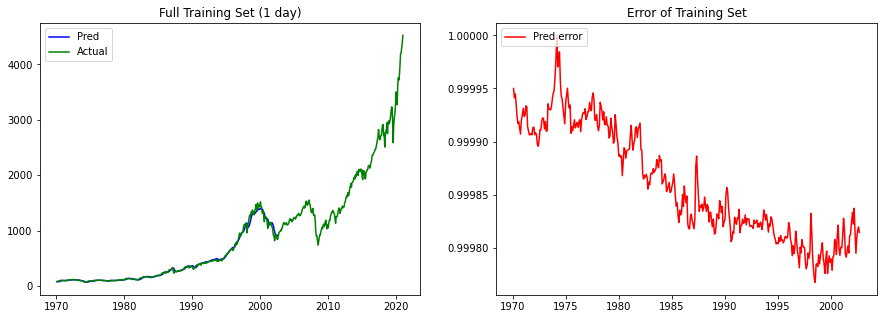

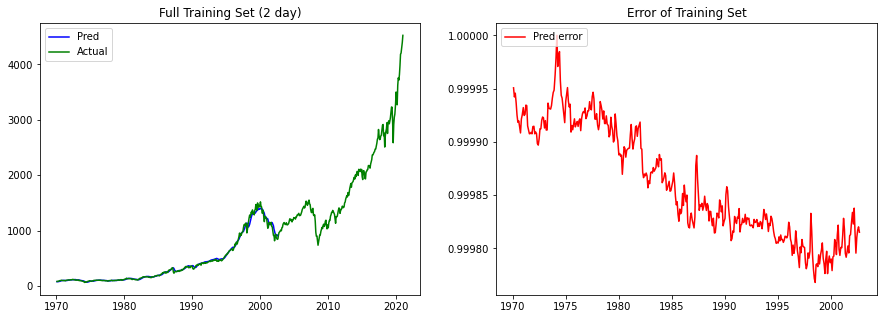

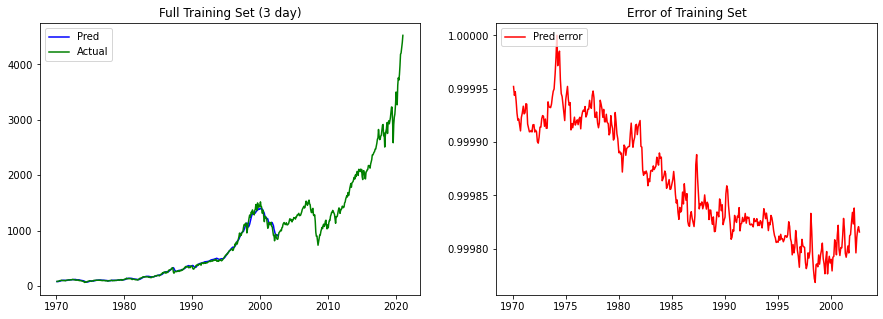

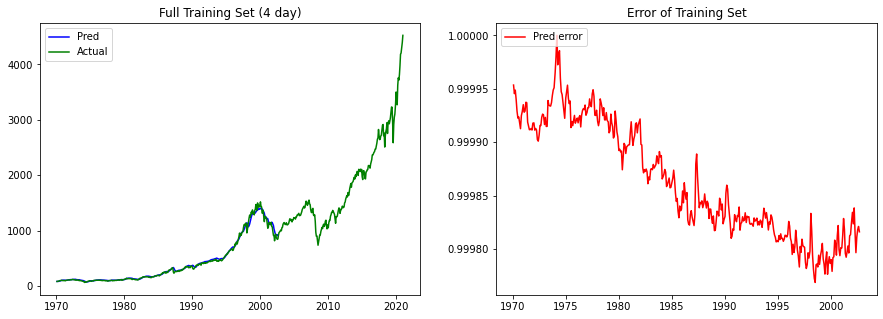

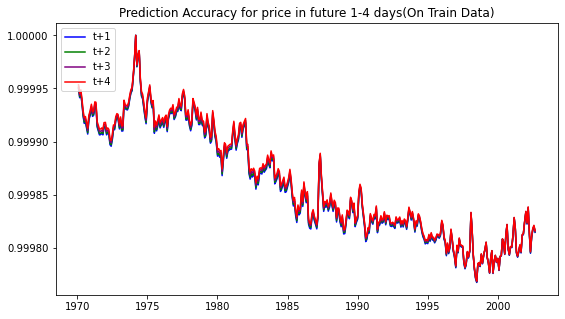

In [18]:
output_plt = output.detach().numpy()

output_plt = output_plt

Y_plt = norm.inverse_transform(Y[:, :, 0])

Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

output_plt1 = norm.inverse_transform(output_plt[:,0].reshape(-1,1))
output_plt2 = norm.inverse_transform(output_plt[:,1].reshape(-1,1))
output_plt3 = norm.inverse_transform(output_plt[:,2].reshape(-1,1))
output_plt4 = norm.inverse_transform(output_plt[:,3].reshape(-1,1))

Y_output = Y_training[:,:,0]

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_output,Y_plt,dateAxis,date_tr,
"Full Training Set (1 day)","Full Training Set (2 day)","Full Training Set (3 day)","Full Training Set (4 day)","Error of Training Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_output,date_tr, 'Prediction Accuracy for price in future 1-4 days(On Train Data)' )

# Step 5 - Test your CNN and RNN accuracy over Test Data

In [19]:
# Calculate the accuracy, make a plot

def prediction_error(pred, actual):
    return abs(pred - actual)/pred




,Mean,STD-dev,Skewness,Kurtosis
1 day,0.425249,0.332052,1.004710,0.533272
2 day,0.422738,0.331356,1.005893,0.534238
3 day,0.425441,0.332912,1.002989,0.529774
4 day,0.427312,0.335209,1.001418,0.527792


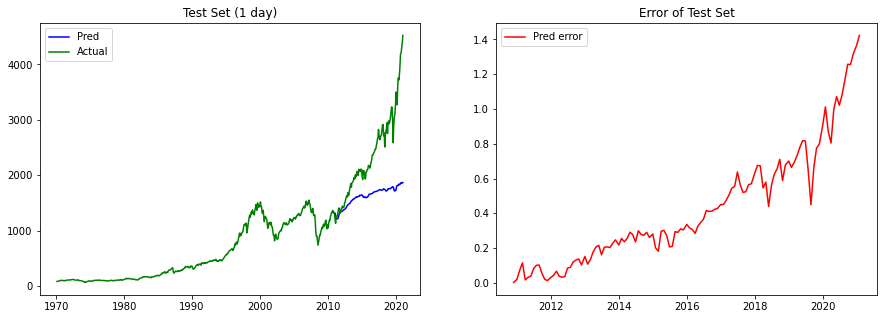

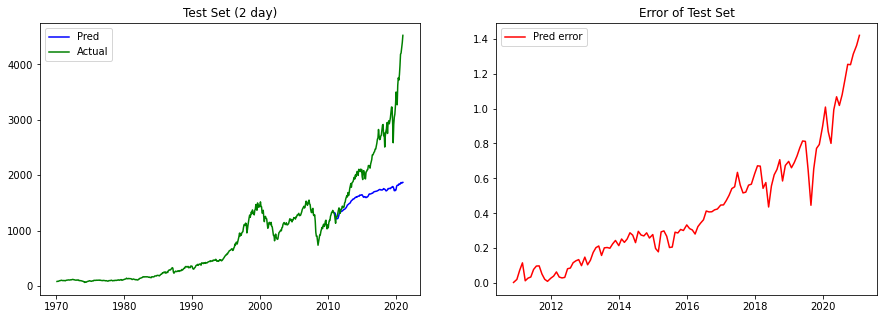

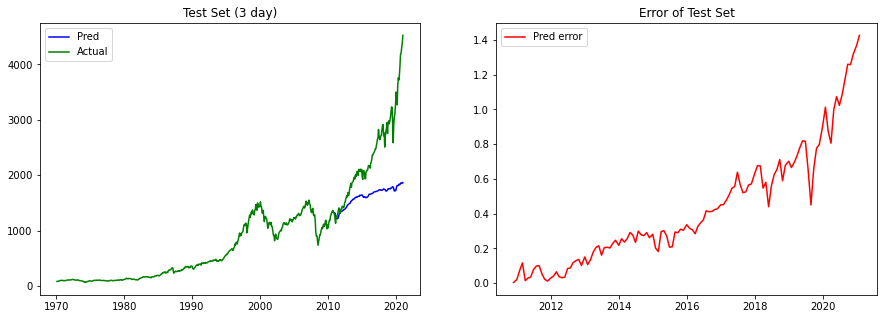

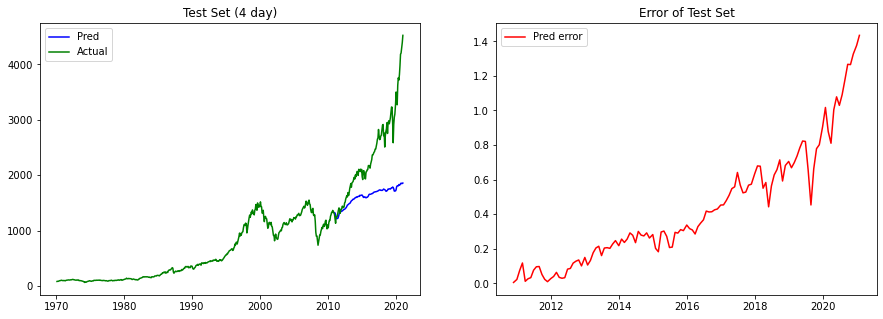

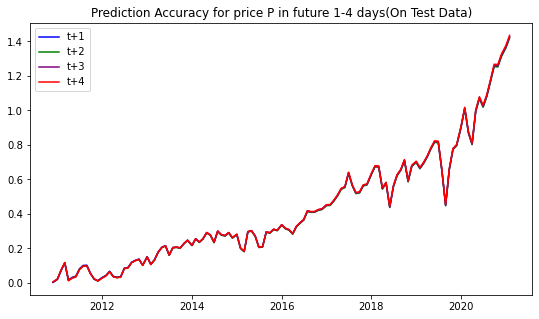

In [20]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,date_t, 'Prediction Accuracy for price P in future 1-4 days(On Test Data)' )

# Step 6 - Optimize your CNN+RNN algorithm's performance 

### Adjust the parameter of the network and enhance the sliding window size

In [21]:
input_size = 4
output_size =4
hidden_dim = 32
n_layers = 2
epochs = 200
window_size = 100


X = []
Y = []
for i in range(trainData.shape[0] - window_size - 4):
    X.append(trainData[i:i+window_size])
    Y.append(targetData[i+window_size:i+window_size+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

dateAxis = []
dateData = []
for i in range(date.shape[0]):
    dateData.append(float(np.squeeze(date)[i][6:10]) + ( (float(np.squeeze(date)[i][0:2])-1)*30 + float(np.squeeze(date)[i][3:5]) )/366 )
dateData = np.array(dateData)
dateAxis = dateData[(window_size+4):]


X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.2, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.2, shuffle=False)

In [22]:
RNN_enhance = Model(input_size, output_size, hidden_dim, n_layers)
RNN_enhance.cnn = CNet(50*20)
optimizer = torch.optim.Adam(RNN_enhance.parameters(), lr=0.001)
criterion = nn.MSELoss()

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, hidden = RNN_enhance(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.020594440400600433
Epoch: 10/200............. Loss: 0.007065022364258766
Epoch: 20/200............. Loss: 0.0029785248916596174
Epoch: 30/200............. Loss: 0.0017509659519419074
Epoch: 40/200............. Loss: 0.0009079728042706847
Epoch: 50/200............. Loss: 0.0006670394213870168
Epoch: 60/200............. Loss: 0.0005147630581632257
Epoch: 70/200............. Loss: 0.00040264669223688543
Epoch: 80/200............. Loss: 0.0003138919419143349
Epoch: 90/200............. Loss: 0.00025044867652468383
Epoch: 100/200............. Loss: 0.0002030782779911533
Epoch: 110/200............. Loss: 0.00017315398145001382
Epoch: 120/200............. Loss: 0.00015191035345196724
Epoch: 130/200............. Loss: 0.0001362533075734973
Epoch: 140/200............. Loss: 0.0001291030930588022
Epoch: 150/200............. Loss: 0.00012311743921600282
Epoch: 160/200............. Loss: 0.00011825311230495572
Epoch: 170/200............. Loss: 0.0001139087544288486

,Mean,STD-dev,Skewness,Kurtosis
1 day,0.550209,0.357270,0.539693,-0.521465
2 day,0.558197,0.350543,0.531941,-0.506600
3 day,0.756507,0.490116,0.763420,-0.110494
4 day,0.638481,0.414490,0.674492,-0.252502


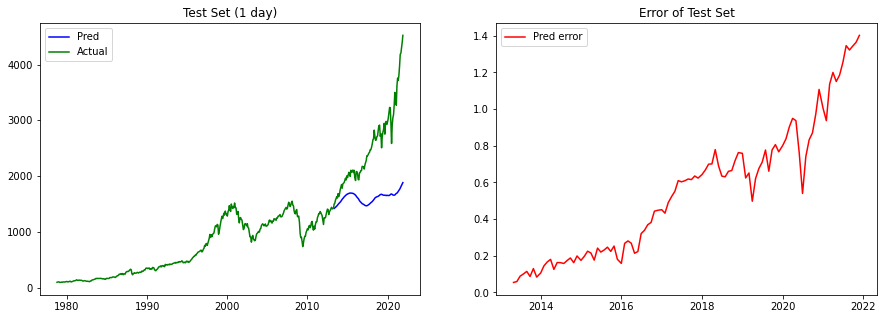

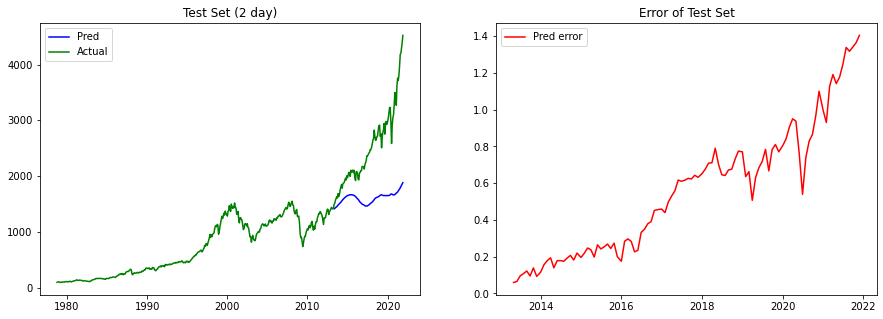

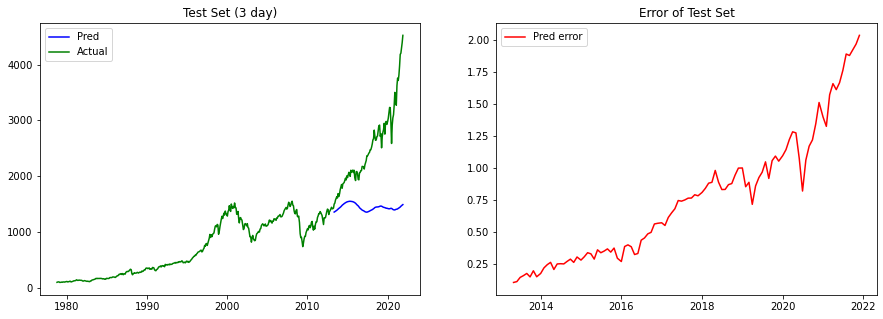

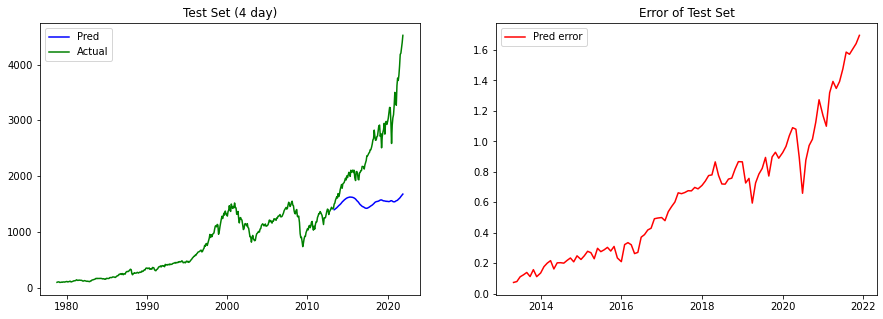

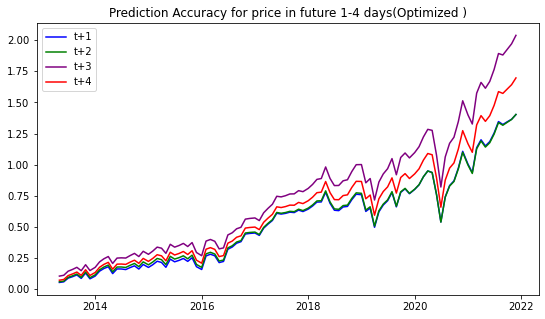

In [23]:
RNN_enhance.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN_enhance(xTensor)

Y_plt = norm.inverse_transform(Y[:, :, 0])

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

plotAccuracy(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,date_t,'Prediction Accuracy for price in future 1-4 days(Optimized )' )

# Step 7 - Enhance your CNN+RNN algorithm's functionality 

(415, 100, 4)
Buy price:  95.61699455470851
Sell price:  242.22631440446293
Money:  2.533297721106157
Buy price:  96.65173631453781
Sell price:  294.8831728491099
Money:  7.729057937874206
Buy price:  98.31359429244549
Sell price:  226.06761985197699
Money:  17.77261572306806
Buy price:  98.31359429244549
Sell price:  259.9214436912408
Money:  46.98723477821685
Buy price:  106.64378805591981
Sell price:  282.51853141599804
Money:  124.47761662291823
Buy price:  106.64378805591981
Sell price:  331.4231444891428
Money:  386.84637775666016
Buy price:  106.64378805591981
Sell price:  336.48188198164166
Money:  1220.5755215398738
Buy price:  633.0869492587735
Sell price:  1127.3590484742072
Money:  2173.519546035772
Buy price:  732.81933180717
Sell price:  1234.1464884759853
Money:  3660.440437288857
Buy price:  803.1922234125309
Sell price:  1259.6492146778387
Money:  5740.681729481468
Buy price:  803.1922234125309
Sell price:  1338.4463674793858
Money:  9566.320967394808
Buy price:  803.1

Text(0, 0.5, 'Money (in millions)')

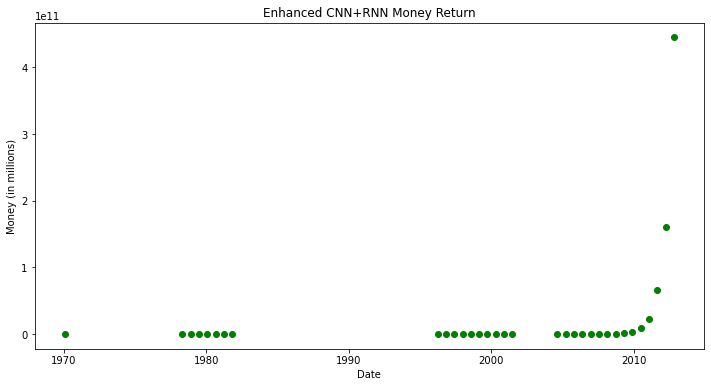

In [24]:
print(X_fullTraining.shape)
# start with $1 m 
money = 1
money_all = []
trade_all = []
date_all = []
money_all.append(money)
date_all.append(dateDigital[0])
sampleNum = 6
# Must buy the new stock before sell
lastsell = -sampleNum

for i in range(1,X.shape[0]):
    tmp = norm.inverse_transform(X[i,:, :])
    
    prob_temp = tmp[:, 2]
    price_temp = tmp[:, 0]
    
    # Sell when has high prob
    if dataset[i][2] > 0.5 and (i-lastsell > sampleNum):
        
        
        # The buy at a low PE ration
        
        buy_price = min(price_temp)
        
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            
            money*= (sell_price/buy_price)
            
            lastsell = i
            money_all.append(money)
            trade_all.append(i)
            date_all.append(dateDigital[i])

plt.figure(figsize=(12, 6));
plt.scatter(date_all,
         money_all, color='green', label='Close')

plt.title('Enhanced CNN+RNN Money Return')
plt.xlabel('Date')
plt.ylabel('Money (in millions)')

# Step 8 - Determine the Effect of Input Data Perturbations(Price Uncertainty) on your Algorithm

## 8a) Using your Optimized CNN+RNN algorithm (from Step 6, above) corrupt your Test Set that you used in Step 5

In [25]:
def add_noisy(dataset, threshold):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set random seed 
    random.seed(1)
    cut_nums = 4
    for i in range(len(dataset)):
        
        s = np.random.normal(0, threshold, cut_nums)
        idx = random.sample(list(range(window_size)), cut_nums)
        dataset_noise[i] = dataset[i] 
        
        #scale the s by the sampling window
        s = max(X_test[1, idx, 0])*s
        tmp = dataset_noise[i, idx, 0] + s
        # modify the data when negative
        tmp[tmp < 0] = 1e-7
        dataset_noise[i, idx, 0]  = tmp
        
    return dataset_noise   

## 8b) Repeat Tests in Step 6, above, with noise-corrupted Test Set.

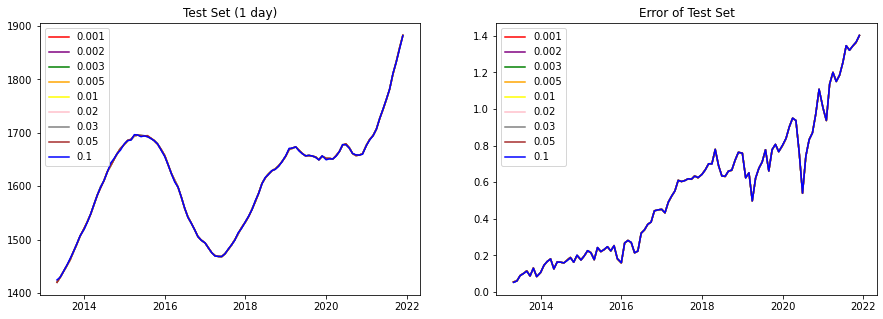

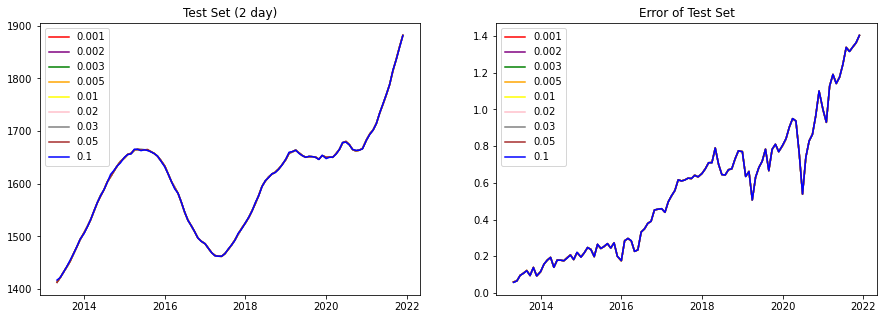

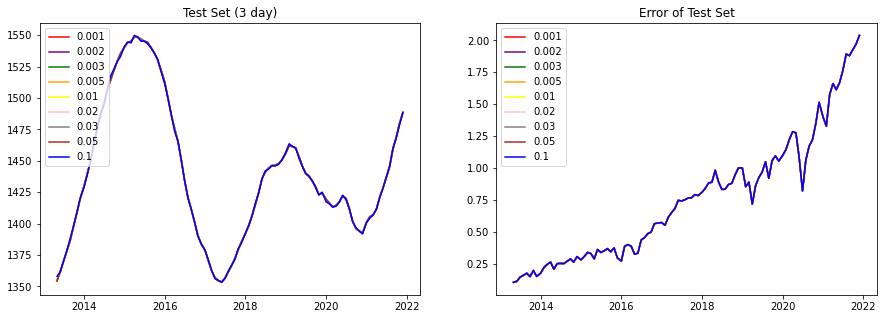

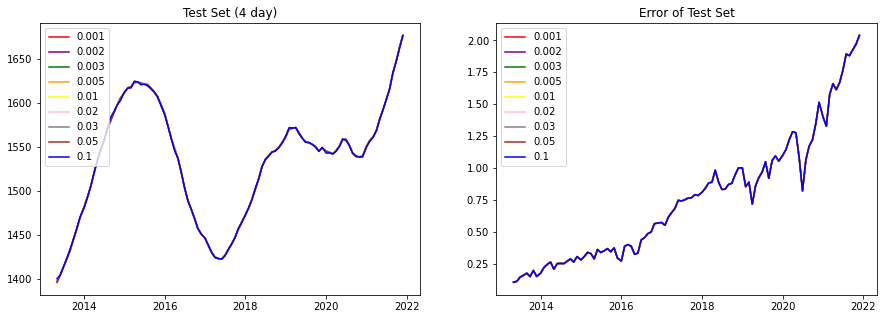

In [26]:
# For the next 1 day: idx=0 

std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1 ]

idx = 0
out_tmp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = norm.inverse_transform(out_tmp)[:, [0]]
error_res_all = []
output_plt1_all=[]
output_plt2_all=[]
output_plt3_all=[]
output_plt4_all=[]

for threshold in std:
    dataset_test_noise = add_noisy(X_test, threshold)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = RNN_enhance(test_inputs)
    out_tmp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    
    predicted_price_test = norm.inverse_transform(out_tmp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

    output_plt1 = output_test.detach().numpy()[:, 0]
    output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))
    output_plt1_all.append(output_plt1)

    output_plt2 = output_test.detach().numpy()[:, 1]
    output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))
    output_plt2_all.append(output_plt2)

    output_plt3 = output_test.detach().numpy()[:, 2]
    output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))
    output_plt3_all.append(output_plt3)

    output_plt4 = output_test.detach().numpy()[:, 3]
    output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))
    output_plt4_all.append(output_plt4)

Y_plt = norm.inverse_transform(Y[:, :, 0])

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotGraphsSD(output_plt1_all,output_plt2_all,output_plt3_all,output_plt4_all,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set",std)


## 8c) Repeat Step 7, above, to Determine How Much Money You Make or Lose

[]

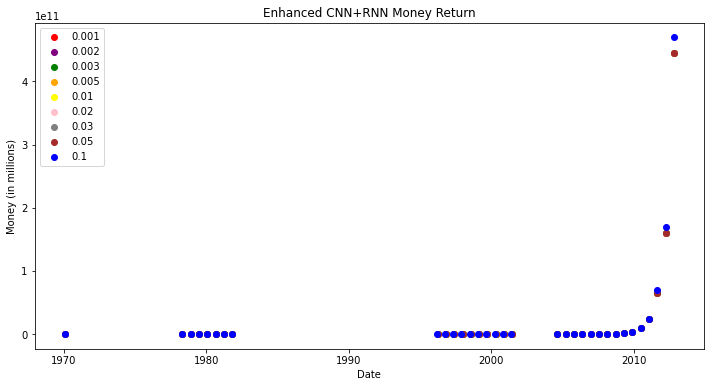

In [27]:
def add_noise1D(outputVector,stdev):
    mean = 0
    noise = np.random.normal(mean,stdev,outputVector.shape)
    return outputVector + noise

plt.figure(figsize=(12, 6));
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown','blue' ]
for index,threshold in enumerate(std):
    # Redoing step 2 in order to add noise to ratio_sp, and thus dataset (which is used in step 7)
    ratio_sp_noise = add_noise1D(ratio_sp, threshold)
    
    record_noise = []
    recordDate_noise = []
    
    for i in range(len(date_sp)):
        tmp = [0 for _ in range(3)]
        tmp[0] = sp_index[i][0]
        record_time = str(date_sp[i][0])
        for j in range(len(ratio_sp)):
            peDate = get_date( array_date_pe[j][0] )

            if(peDate is not None and len(peDate)==3) :
                if(record_time[6:10]==peDate[2] ):
                        if(peDate[1]==record_time[0:2] or ('0'+peDate[1])==record_time[0:2]):
                            tmp[1] = ratio_sp_noise[j]
                            recordDate_noise.append(record_time)
                            record_noise.append(tmp)
    
    dataset_noise = np.array(record_noise)
    sampleNum = 100
    for i in range(sampleNum-1 ,len(dataset)):
        # Pearson  r
        x = dataset_noise[(i-sampleNum+1):(i+1), 0]
        y = dataset_noise[(i-sampleNum+1):(i+1), 1]
        r = np.corrcoef(x, y)
        dataset_noise[i][2] = r[0,1] # Here is where we create noisy data used for step 8c

    # start with $1 m 
    money = 1
    money_all = []
    trade_all = []
    date_all = []
    money_all.append(money)
    date_all.append(dateDigital[0])
    sampleNum = 6
    # Must buy the new stock before sell
    lastsell = -sampleNum

    for i in range(1,X.shape[0]):
        tmp = norm.inverse_transform(X[i,:, :])

        prob_temp = tmp[:, 2]
        price_temp = tmp[:, 0]

        # Sell when has high prob
        if dataset_noise[i][2] > 0.5 and (i-lastsell > sampleNum): # Just repeating step 7, but using dataset_noise


            # The buy at a low PE ration

            buy_price = min(price_temp)

            if buy_price > 0:
                sell_price = price_temp[len(price_temp)-1]

                money*= (sell_price/buy_price)

                lastsell = i
                money_all.append(money)
                trade_all.append(i)
                date_all.append(dateDigital[i])
    
    plt.scatter(np.squeeze(date_all), money_all, color=cmaps[index], label=std[index])

plt.legend(loc="upper left")
plt.title('Enhanced CNN+RNN Money Return')
plt.xlabel('Date')
plt.ylabel('Money (in millions)')
plt.plot()

# Step 9 - Modify the CNN+RNN algorithm in this assignment to generate a BUY signal as well as a SELL signal.  Then optimize your enhanced algorithm as stated in Steps 5 and 6. 